# 03 EDA de data procesada (ALL / STRICT / POR SUJETO)

## Setup, rutas y utilidades

Inicializa rutas de salida para el EDA post, define utilidades para cargar Epochs procesados (ALL/STRICT/SUBJECT), orden de clases, búsqueda de canales motores y funciones robustas para calcular bandpower (Welch), además de parámetros de bandas (mu/beta).

In [4]:
# [EDA POST] Setup, rutas y utilidades
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mne
import re

# Rutas base (ajusta si tu notebook vive en otra carpeta)
PROJ       = Path('..').resolve()
DATA_PROC  = PROJ / 'data' / 'processed'
REPORT_FIG = PROJ / 'reports' / 'figures' / '03_proc_eda'
REPORT_TAB = PROJ / 'reports' / 'tables'  / '03_proc_eda'
REPORT_FIG.mkdir(parents=True, exist_ok=True)
REPORT_TAB.mkdir(parents=True, exist_ok=True)

# Fuente a auditar: 'ALL' | 'STRICT' | 'SUBJECT'
SOURCE      = 'STRICT'
SUBJECT_ID  = 'S001'

# Bandas y tokens motores
FREQ_BANDS  = {'mu': (8, 12), 'beta': (13, 30)}
MOTOR_TOKENS = ['C3','Cz','C4']

def _resolve_source():
    """Devuelve la ruta al FIF según SOURCE."""
    if SOURCE.upper() == 'ALL':
        p = DATA_PROC / 'all_subjects-epo.fif'
    elif SOURCE.upper() == 'STRICT':
        p = DATA_PROC / 'strict_subjects-epo.fif'
    elif SOURCE.upper() == 'SUBJECT':
        p = DATA_PROC / f'{SUBJECT_ID}_MI-epo.fif'
    else:
        raise ValueError("SOURCE debe ser 'ALL', 'STRICT' o 'SUBJECT'")
    if not p.exists():
        raise FileNotFoundError(f"No existe el archivo: {p}")
    return p

def _class_order(event_id: dict):
    """Orden consistente para reportes."""
    pref = ['Left','Right','Both Fists','Both Feet']
    return [c for c in pref if c in event_id] or sorted(event_id.keys())

def _find_motor_chs(ch_names, tokens=MOTOR_TOKENS):
    """
    Busca C3, Cz, C4 con tolerancia:
      1) coincide exacto (case-insensitive)
      2) si no, fallback por subcadena
    """
    up = [c.upper() for c in ch_names]
    idx_exact = []
    for tok in tokens:
        TU = tok.upper()
        try:
            idx_exact.append(up.index(TU))
        except ValueError:
            idx_exact.append(None)
    # Fallback por subcadena
    for k, tok in enumerate(tokens):
        if idx_exact[k] is not None:
            continue
        TU = tok.upper()
        hit = next((i for i, nm in enumerate(up) if TU in nm), None)
        idx_exact[k] = hit
    return [i for i in idx_exact if i is not None]

def _bandpower_epochs(epochs: mne.Epochs, fmin: float, fmax: float):
    """
    Bandpower promedio por canal (sobre épocas) vía Welch: (n_channels,)
    Robusto a tamaños cortos: calcula n_per_seg adaptativo.
    """
    sf = float(epochs.info['sfreq'])
    n_times   = int(epochs.get_data().shape[-1])
    n_per_seg = int(min(n_times, max(128, sf * 1.0)))  # ~1 s, mínimo 128
    n_fft     = int(2 ** np.ceil(np.log2(n_per_seg)))
    n_overlap = int(0.5 * n_per_seg)
    # API moderna de MNE
    psd_obj = epochs.compute_psd(
        method='welch',
        fmin=fmin, fmax=fmax,
        n_fft=n_fft, n_per_seg=n_per_seg, n_overlap=n_overlap,
        picks='eeg', verbose=False
    )
    psd   = psd_obj.get_data()   # (n_epochs, n_channels, n_freqs)
    freqs = psd_obj.freqs
    # Integrar potencia por canal y promediar sobre épocas
    bp = np.trapezoid(psd, freqs, axis=-1).mean(axis=0)  # (n_channels,)
    return bp

def _emg_ratio_20_40(epochs: mne.Epochs, picks=None):
    """
    Aproximación de “EMG ratio”: potencia [20–40] / potencia [8–12] en promedio
    (por defecto en canales motores si picks=None).
    Devuelve un escalar (promedio sobre canales elegidos).
    """
    if picks is None:
        picks = _find_motor_chs(epochs.ch_names)
        if not picks:  # si no hay motores, usa todos
            picks = mne.pick_types(epochs.info, eeg=True)
    # Bandpower en cada banda
    bp_mu    = _bandpower_epochs(epochs.copy().pick(picks), 8, 12)     # (n_ch,)
    bp_20_40 = _bandpower_epochs(epochs.copy().pick(picks), 20, 40)    # (n_ch,)
    ratio = (bp_20_40 / np.maximum(bp_mu, 1e-12)).mean()
    return float(ratio)


## Carga del FIF, QA y balance de clases (figura)

Carga el archivo de Epochs procesado (ALL/STRICT/SUBJECT), imprime QA básica (n_epochs, sfreq, n_channels), guarda balance por clase y genera la figura de barras.

FIF: strict_subjects-epo.fif
Shape: (7276, 64, 641) | sfreq: 160.0 | n_channels: 64
Clases: {'Left': 1, 'Right': 2, 'Both Fists': 3, 'Both Feet': 4}


,file,n_epochs,sfreq,n_channels
0,strict_subjects-epo.fif,7276,160.0,64


,y_class,count
0,Left,1838
1,Right,1805
2,Both Fists,1806
3,Both Feet,1827


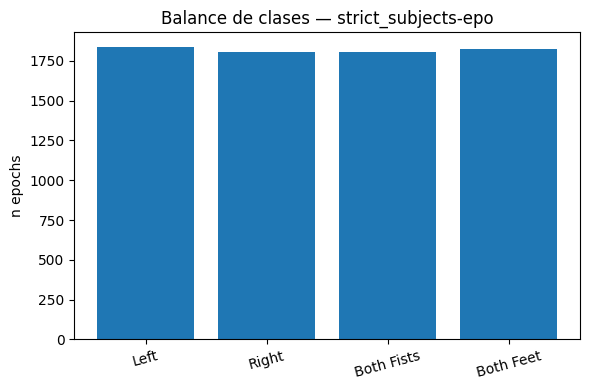

Figura guardada: C:\Users\joelc\Desktop\eeg2\reports\figures\03_proc_eda\strict_subjects-epo_class_balance.png


In [5]:
# [EDA POST] Carga, QA y balance de clases
fif_path = _resolve_source()
epochs   = mne.read_epochs(fif_path, preload=True, verbose=False)

print("FIF:", fif_path.name)
print("Shape:", epochs.get_data().shape,
      "| sfreq:", epochs.info['sfreq'],
      "| n_channels:", len(epochs.ch_names))
print("Clases:", epochs.event_id)

# QA rápida
qa = {
    'file': fif_path.name,
    'n_epochs': len(epochs),
    'sfreq': float(epochs.info['sfreq']),
    'n_channels': len(epochs.ch_names),
}
df_qa = pd.DataFrame([qa])
display(df_qa)
df_qa.to_csv(REPORT_TAB / f'{fif_path.stem}_QA.csv', index=False)

# Balance por clase
order = _class_order(epochs.event_id)
rows  = [{'y_class': c, 'count': len(epochs[c]) if c in epochs.event_id else 0} for c in order]
df_counts = pd.DataFrame(rows)
display(df_counts)
out_counts = REPORT_TAB / f'{fif_path.stem}_class_balance.csv'
df_counts.to_csv(out_counts, index=False)

# Figura: barras de balance
plt.figure(figsize=(6,4))
plt.bar(df_counts['y_class'], df_counts['count'])
plt.title(f'Balance de clases — {fif_path.stem}')
plt.ylabel('n epochs')
plt.xticks(rotation=15)
plt.tight_layout()
out_png = REPORT_FIG / f'{fif_path.stem}_class_balance.png'
plt.savefig(out_png, dpi=140); plt.show()
print("Figura guardada:", out_png)


## PSD por clase en C3/Cz/C4

Detecta canales motores y, por cada clase, dibuja PSD promedio 1–60 Hz en C3/Cz/C4. Sirve para ver cómo quedó el espectro tras tu pipeline.

In [6]:
# [EDA POST] PSD por clase en canales motores
motor_idx = _find_motor_chs(epochs.ch_names)
motor_names = [epochs.ch_names[i] for i in motor_idx] if motor_idx else []
print("Canales motores:", motor_names if motor_names else "—")

if motor_idx:
    for cname in _class_order(epochs.event_id):
        if cname not in epochs.event_id or len(epochs[cname]) == 0:
            continue
        ep_cls = epochs[cname]
        try:
            fig = ep_cls.plot_psd(fmin=1, fmax=60, picks=motor_idx, average=True, show=False)
            fig.suptitle(f'PSD {cname} — {fif_path.stem} — {", ".join(motor_names)}', y=1.02)
            out_png = REPORT_FIG / f'{fif_path.stem}_PSD_{cname}_C3CzC4.png'
            fig.savefig(out_png, dpi=140, bbox_inches='tight')
            plt.close(fig)
            print("PSD guardada:", out_png)
        except Exception as e:
            print(f"PSD no disponible para {cname}: {e}")


Canales motores: ['C3', 'Cz', 'C4']
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs before plotting...
PSD guardada: C:\Users\joelc\Desktop\eeg2\reports\figures\03_proc_eda\strict_subjects-epo_PSD_Left_C3CzC4.png
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs before plotting...
PSD guardada: C:\Users\joelc\Desktop\eeg2\reports\figures\03_proc_eda\strict_subjects-epo_PSD_Right_C3CzC4.png
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs before plotting...
PSD guardada: C:\Users\joelc\Desktop\eeg2\reports\figure

## Topomap de bandpower (mu/beta) por clase

Calcula bandpower por canal en mu y beta y dibuja topomapas por clase (si hay posiciones/“montage” en epochs.info['dig']). Si no, guarda un CSV con los valores.

In [7]:
# [EDA POST] Topomap de bandpower (mu/beta) por clase
def _safe_plot_topomap(values, info, title, out_png):
    """Dibuja topomap si hay posiciones; si no, guarda CSV."""
    try:
        if not info.get('dig'):
            raise RuntimeError("sin posiciones (montage)")
        fig, ax = plt.subplots(figsize=(6,5))
        im, _ = mne.viz.plot_topomap(values, info, axes=ax, show=False)
        ax.set_title(title)
        fig.colorbar(im, ax=ax, shrink=0.75)
        fig.savefig(out_png, dpi=140, bbox_inches='tight')
        plt.close(fig)
        print("Topomap guardado:", out_png)
    except Exception as e:
        out_csv = Path(str(out_png).replace('.png', '.csv'))
        pd.DataFrame({'ch': info['ch_names'], 'value': values}).to_csv(out_csv, index=False)
        print(f"Topomap no dibujado ({e}). Guardado CSV:", out_csv)

for band_name, (fmin, fmax) in FREQ_BANDS.items():
    for cname in _class_order(epochs.event_id):
        if cname not in epochs.event_id or len(epochs[cname]) == 0:
            continue
        ep_cls = epochs[cname]
        bp = _bandpower_epochs(ep_cls, fmin, fmax)  # (n_channels,)
        title   = f'{band_name.upper()} {fmin}-{fmax} Hz — {cname} — {fif_path.stem}'
        out_png = REPORT_FIG / f'{fif_path.stem}_TOPO_{band_name}_{cname}.png'
        _safe_plot_topomap(bp, ep_cls.info, title, out_png)


Topomap guardado: C:\Users\joelc\Desktop\eeg2\reports\figures\03_proc_eda\strict_subjects-epo_TOPO_mu_Left.png
Topomap guardado: C:\Users\joelc\Desktop\eeg2\reports\figures\03_proc_eda\strict_subjects-epo_TOPO_mu_Right.png
Topomap guardado: C:\Users\joelc\Desktop\eeg2\reports\figures\03_proc_eda\strict_subjects-epo_TOPO_mu_Both Fists.png
Topomap guardado: C:\Users\joelc\Desktop\eeg2\reports\figures\03_proc_eda\strict_subjects-epo_TOPO_mu_Both Feet.png
Topomap guardado: C:\Users\joelc\Desktop\eeg2\reports\figures\03_proc_eda\strict_subjects-epo_TOPO_beta_Left.png
Topomap guardado: C:\Users\joelc\Desktop\eeg2\reports\figures\03_proc_eda\strict_subjects-epo_TOPO_beta_Right.png
Topomap guardado: C:\Users\joelc\Desktop\eeg2\reports\figures\03_proc_eda\strict_subjects-epo_TOPO_beta_Both Fists.png
Topomap guardado: C:\Users\joelc\Desktop\eeg2\reports\figures\03_proc_eda\strict_subjects-epo_TOPO_beta_Both Feet.png


## Métricas POST por sujeto (comparables con RAW)

Recorre todos los S???_MI-epo.fif y calcula métricas comparables por sujeto. Se guarda metrics_proc_subject.csv. Si existe metrics_raw_subject.csv, crea además metrics_compare_subject.csv uniendo por subject.

- n_epochs: total de epochs por sujeto

- count_*: balance por clase

- emg_ratio_20_40: potencia 20–40 / 8–12 en canales motores

- bandpower_motor_mu_mean, bandpower_motor_beta_mean

- silhouette_logvar_post: separabilidad (log-var por canal; motores si existen, si no todos)

In [8]:
# [EDA POST] Métricas por sujeto y comparación con RAW (si disponible)
from glob import glob
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

def _per_subject_files(proc_dir=DATA_PROC):
    return sorted(glob(str(proc_dir / 'S???_MI-epo.fif')))

def _metrics_for_subject(fif_path: Path):
    ep = mne.read_epochs(fif_path, preload=True, verbose=False)
    # Conteos por clase
    order = _class_order(ep.event_id)
    counts = {f'count_{c}': int(len(ep[c])) if c in ep.event_id else 0 for c in order}
    # EMG ratio 20–40 / 8–12 en motores
    emg_ratio = _emg_ratio_20_40(ep, picks=None)
    # Bandpower mu/beta en motores (promedio sobre canales motores)
    motor_idx = _find_motor_chs(ep.ch_names)
    picks = motor_idx if motor_idx else mne.pick_types(ep.info, eeg=True)
    bp_mu    = _bandpower_epochs(ep.copy().pick(picks), 8, 12).mean()
    bp_beta  = _bandpower_epochs(ep.copy().pick(picks), 13, 30).mean()
    # Silhouette (log-var por canal, motores si hay)
    X = np.log(np.var(ep.get_data(picks=picks), axis=-1) + 1e-8)  # (n_epochs, n_ch_sel)
    # Etiquetas: usa nombres de clase según event_id y events
    inv = {v:k for k,v in ep.event_id.items()}
    y_str = np.array([inv[e[-1]] for e in ep.events], dtype=object)
    sil = np.nan
    if len(np.unique(y_str)) >= 2 and X.shape[0] > 10:
        Xz = StandardScaler().fit_transform(X)
        try:
            sil = float(silhouette_score(Xz, y_str, metric='euclidean'))
        except Exception:
            pass
    row = dict(
        subject=fif_path.name.split('_')[0],
        n_epochs=int(len(ep)),
        sfreq=float(ep.info['sfreq']),
        n_channels=len(ep.ch_names),
        emg_ratio_20_40=emg_ratio,
        bandpower_motor_mu_mean=float(bp_mu),
        bandpower_motor_beta_mean=float(bp_beta),
        silhouette_logvar_post=sil,
        motor_channels_found=int(len(motor_idx) > 0),
    )
    row.update(counts)
    return row

# Recorre todos los sujetos procesados
rows = []
for p in _per_subject_files(DATA_PROC):
    try:
        rows.append(_metrics_for_subject(Path(p)))
    except Exception as e:
        print("No se pudo procesar", p, "→", e)

df_metrics_post = pd.DataFrame(rows).sort_values('subject')
display(df_metrics_post.head(10))
out_post = REPORT_TAB / 'metrics_proc_subject.csv'
df_metrics_post.to_csv(out_post, index=False)
print("Métricas POST por sujeto guardadas en:", out_post)

# Comparación con RAW (si existe)
raw_metrics_path = PROJ / 'reports' / 'tables' / 'EDA_raw' / 'metrics_raw_subject.csv'
if raw_metrics_path.exists():
    df_raw = pd.read_csv(raw_metrics_path)
    # Elegimos campos comparables/claves
    keep_raw = [
        'subject',
        'n_runs_mi',
        'n_events_left','n_events_right','n_events_fists','n_events_feet',
        'std_uV_median','p99_uV_median',
        'silhouette_logvar_raw'
    ]
    df_raw_small = df_raw[keep_raw]
    # Unimos
    df_cmp = pd.merge(df_raw_small, df_metrics_post, on='subject', how='inner')
    out_cmp = REPORT_TAB / 'metrics_compare_subject.csv'
    df_cmp.to_csv(out_cmp, index=False)
    print("Comparación RAW vs POST guardada en:", out_cmp)
    display(df_cmp.head(10))
else:
    print("No se encontró metrics_raw_subject.csv; saltando comparación.")


,subject,n_epochs,sfreq,n_channels,emg_ratio_20_40,bandpower_motor_mu_mean,bandpower_motor_beta_mean,silhouette_logvar_post,motor_channels_found,count_Left,count_Right,count_Both Fists,count_Both Feet
0,S001,88,160.0,64,1.079012,2.110568e-11,3.963796e-11,0.037226,1,23,21,21,23
1,S002,84,160.0,64,2.434810,1.279802e-11,3.970998e-11,-0.110195,1,21,21,21,21
2,S003,83,160.0,64,0.827317,2.284165e-11,2.863710e-11,-0.084972,1,23,20,20,20
3,S004,72,160.0,64,3.134331,2.041035e-12,9.626806e-12,0.012074,1,16,17,20,19
4,S005,84,160.0,64,1.795372,4.309640e-12,1.167829e-11,-0.096912,1,21,21,21,21
5,S006,82,160.0,64,6.643889,3.835438e-12,2.999050e-11,-0.112398,1,20,20,21,21
6,S007,89,160.0,64,0.223512,3.872977e-11,1.890851e-11,-0.032159,1,23,22,21,23
7,S008,84,160.0,64,0.625348,1.118601e-11,1.076513e-11,-0.050952,1,21,21,21,21
8,S009,2,160.0,64,1.565406,3.036160e-11,6.790130e-11,NaN,1,1,0,1,0
9,S010,83,160.0,64,0.581785,2.930752e-11,3.496522e-11,-0.061546,1,21,20,21,21


Métricas POST por sujeto guardadas en: C:\Users\joelc\Desktop\eeg2\reports\tables\03_proc_eda\metrics_proc_subject.csv
No se encontró metrics_raw_subject.csv; saltando comparación.


## t-SNE 2D (post) en un sujeto ejemplo

Visualización rápida de separabilidad tras el preprocesamiento usando log-var por canal (motores si existen). Útil para ilustrar mejoras visuales respecto al t-SNE RAW.

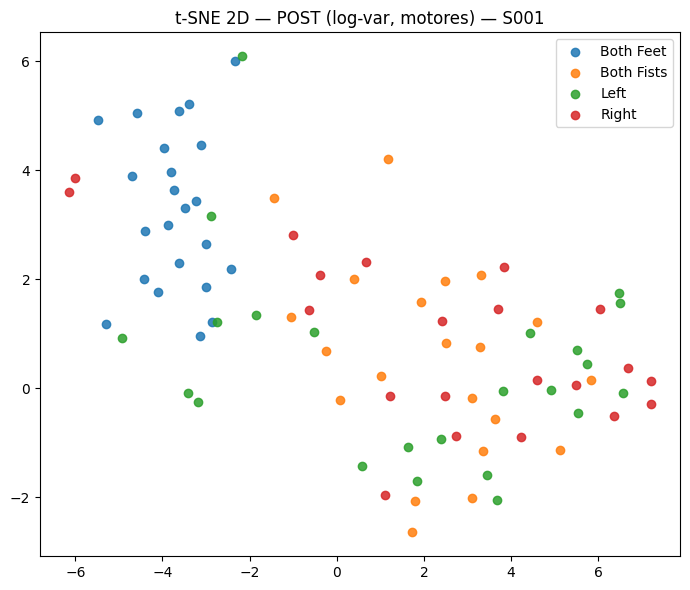

t-SNE POST guardado en: C:\Users\joelc\Desktop\eeg2\reports\figures\03_proc_eda\S001_tsne2d_post_motores.png


In [9]:
# [EDA POST] t-SNE 2D (post) en un sujeto ejemplo
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

def tsne_post_example(subject_id='S001', use_motor_only=True, random_state=42):
    fif = DATA_PROC / f'{subject_id}_MI-epo.fif'
    if not fif.exists():
        print("No existe:", fif)
        return
    ep = mne.read_epochs(fif, preload=True, verbose=False)
    motor_idx = _find_motor_chs(ep.ch_names)
    picks = motor_idx if (use_motor_only and motor_idx) else mne.pick_types(ep.info, eeg=True)

    X = np.log(np.var(ep.get_data(picks=picks), axis=-1) + 1e-8)
    inv = {v:k for k,v in ep.event_id.items()}
    y  = np.array([inv[e[-1]] for e in ep.events], dtype=object)

    if len(np.unique(y)) < 2 or X.shape[0] <= 10:
        print("t-SNE no informativo (pocas clases o pocos epochs).")
        return

    Xz = StandardScaler().fit_transform(X)
    perp = max(5, min(30, Xz.shape[0] // 3))
    Z2 = TSNE(n_components=2, init="pca", perplexity=perp,
              learning_rate="auto", max_iter=1500,
              random_state=random_state).fit_transform(Xz)

    plt.figure(figsize=(7,6))
    for lbl in np.unique(y):
        sel = (y == lbl)
        plt.scatter(Z2[sel,0], Z2[sel,1], alpha=0.85, label=lbl)
    lab = "motores" if (use_motor_only and motor_idx) else "todos"
    plt.title(f"t-SNE 2D — POST (log-var, {lab}) — {subject_id}")
    plt.legend()
    plt.tight_layout()
    out_png = REPORT_FIG / f'{subject_id}_tsne2d_post_{lab}.png'
    plt.savefig(out_png, dpi=150); plt.show()
    print("t-SNE POST guardado en:", out_png)

# Ejecuta con el sujeto del SOURCE si corresponde, o el que prefieras
sid = SUBJECT_ID if SOURCE.upper() == 'SUBJECT' else 'S001'
tsne_post_example(sid, use_motor_only=True)


## Resumen y visualizaciones RAW vs POST

Lee y consolida las métricas comparables entre el EDA RAW y el EDA POST.

Métricas clave y salidas:

- silhouette_logvar_raw vs silhouette_logvar_post y su delta.

- Distribución de emg_ratio_20_40 (POST).

- Tablas: resumen estadístico y top sujetos por mejora/decaída.

- Figuras:

    - Dispersión silhouette (POST vs RAW) con línea y=x

    - Boxplot silhouette (RAW vs POST)

    - Histograma del delta silhouette (POST − RAW)

    - Boxplot de emg_ratio_20_40 (POST)

Todos los CSV y PNG se guardan bajo reports/tables/03_proc_eda y reports/figures/03_proc_eda.

Comparación RAW vs POST — shape: (103, 28)


,subject,subject_num,subject_raw,subject_tag_raw,n_runs_mi,n_events_left,n_events_right,n_events_fists,n_events_feet,std_uV_median,...,bandpower_motor_mu_mean,bandpower_motor_beta_mean,silhouette_logvar_post,motor_channels_found,count_Left,count_Right,count_Both Fists,count_Both Feet,delta_silhouette,emg_per_p99
0,S001,1,1,S001,6,23,22,21,24,52.197511,...,2.110568e-11,3.963796e-11,0.037226,1,23,21,21,23,0.040273,0.007599
1,S002,2,2,S002,6,23,22,24,21,20.946377,...,1.279802e-11,3.970998e-11,-0.110195,1,21,21,21,21,0.023709,0.039271
2,S003,3,3,S003,6,23,22,21,24,52.387219,...,2.284165e-11,2.863710e-11,-0.084972,1,23,20,20,20,0.006261,0.005826
3,S004,4,4,S004,6,23,22,22,23,36.402239,...,2.041035e-12,9.626806e-12,0.012074,1,16,17,20,19,0.109226,0.030729
4,S005,5,5,S005,6,21,24,23,22,43.878352,...,4.309640e-12,1.167829e-11,-0.096912,1,21,21,21,21,-0.034079,0.015888
5,S006,6,6,S006,6,24,21,22,23,19.438997,...,3.835438e-12,2.999050e-11,-0.112398,1,20,20,21,21,0.015431,0.116559
6,S007,7,7,S007,6,23,22,22,23,40.988794,...,3.872977e-11,1.890851e-11,-0.032159,1,23,22,21,23,0.044422,0.002191
7,S008,8,8,S008,6,22,23,23,22,32.112222,...,1.118601e-11,1.076513e-11,-0.050952,1,21,21,21,21,0.078040,0.006948
8,S009,9,9,S009,6,24,21,23,22,84.088265,...,3.036160e-11,6.790130e-11,NaN,1,1,0,1,0,NaN,0.006442
9,S010,10,10,S010,6,24,21,23,22,114.736314,...,2.930752e-11,3.496522e-11,-0.061546,1,21,20,21,21,0.088198,0.001834


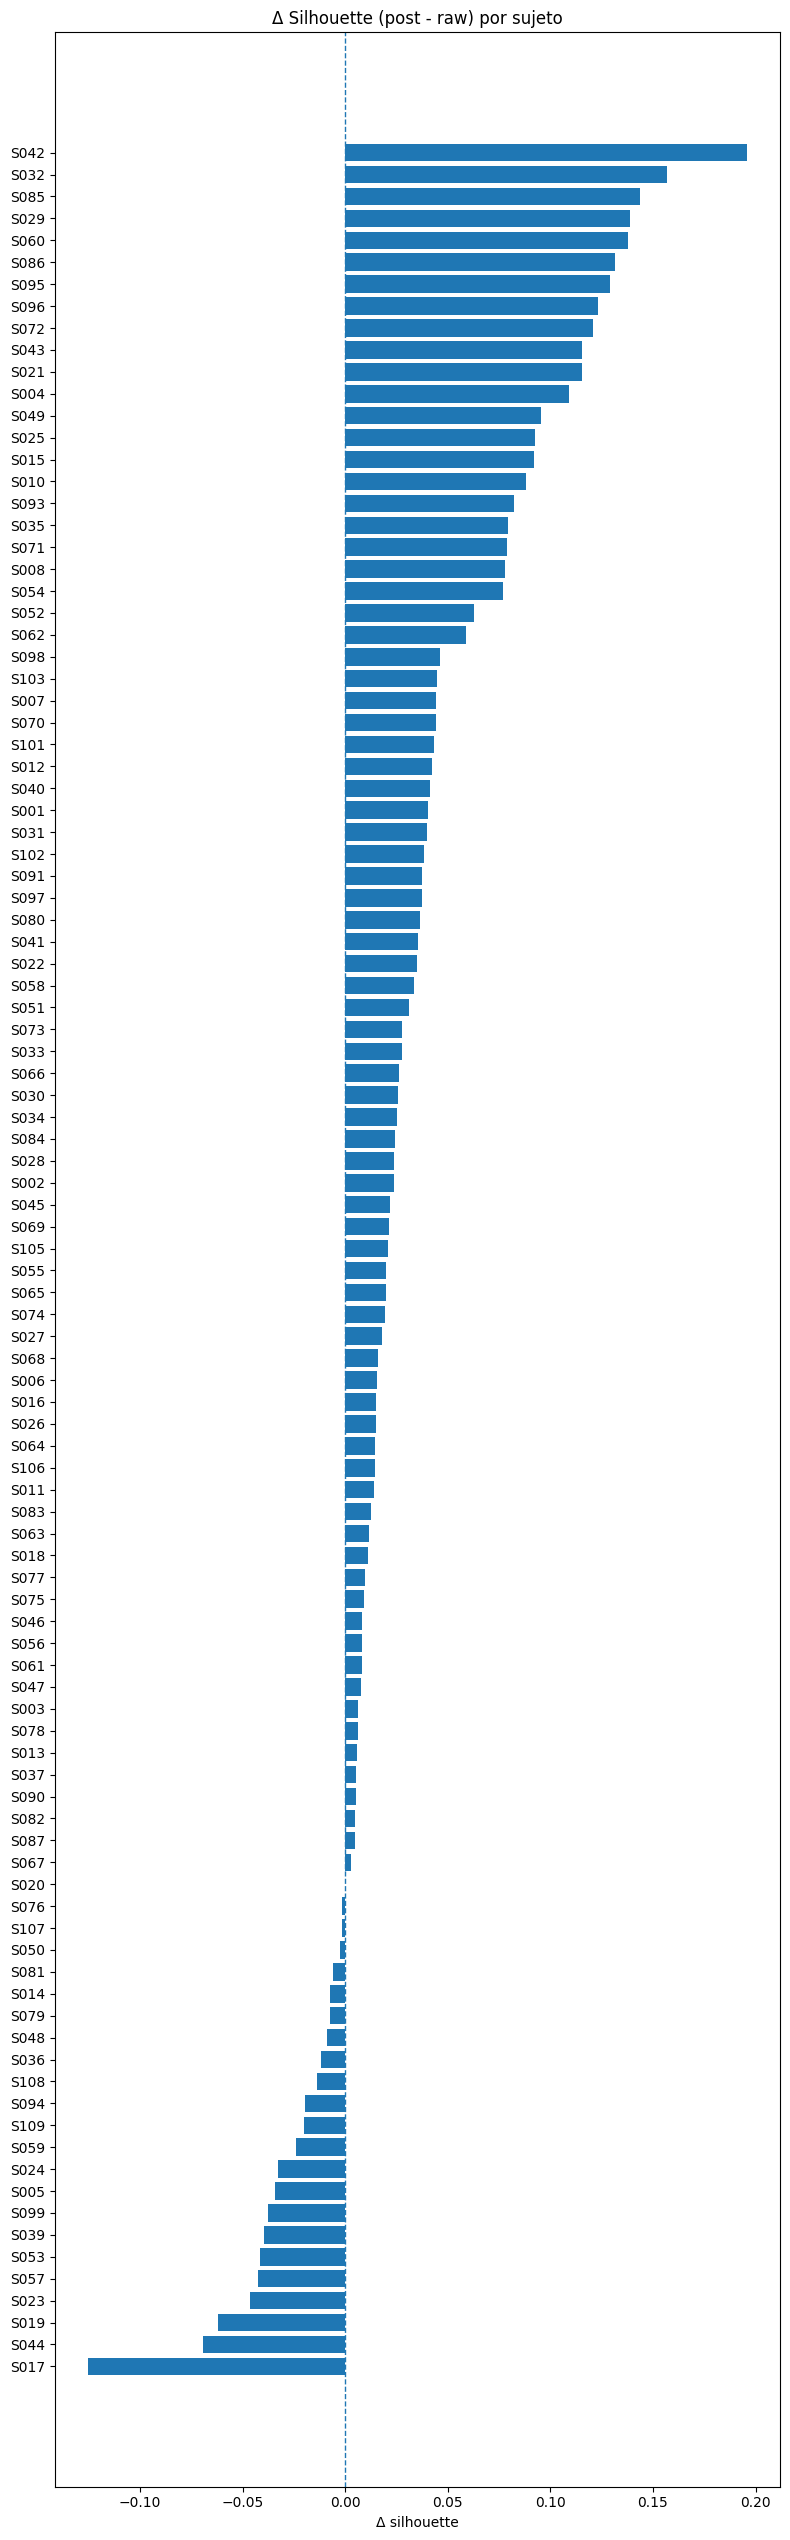

Figura guardada: C:\Users\joelc\Desktop\eeg2\reports\figures\03_proc_eda\cmp_delta_silhouette_barh.png


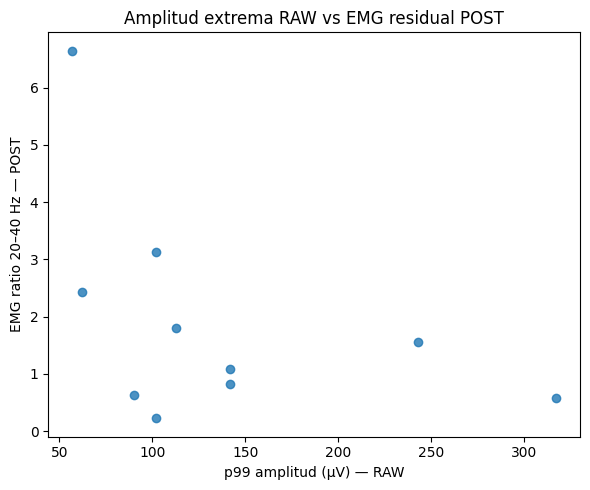

Figura guardada: C:\Users\joelc\Desktop\eeg2\reports\figures\03_proc_eda\cmp_p99_vs_emg_scatter.png


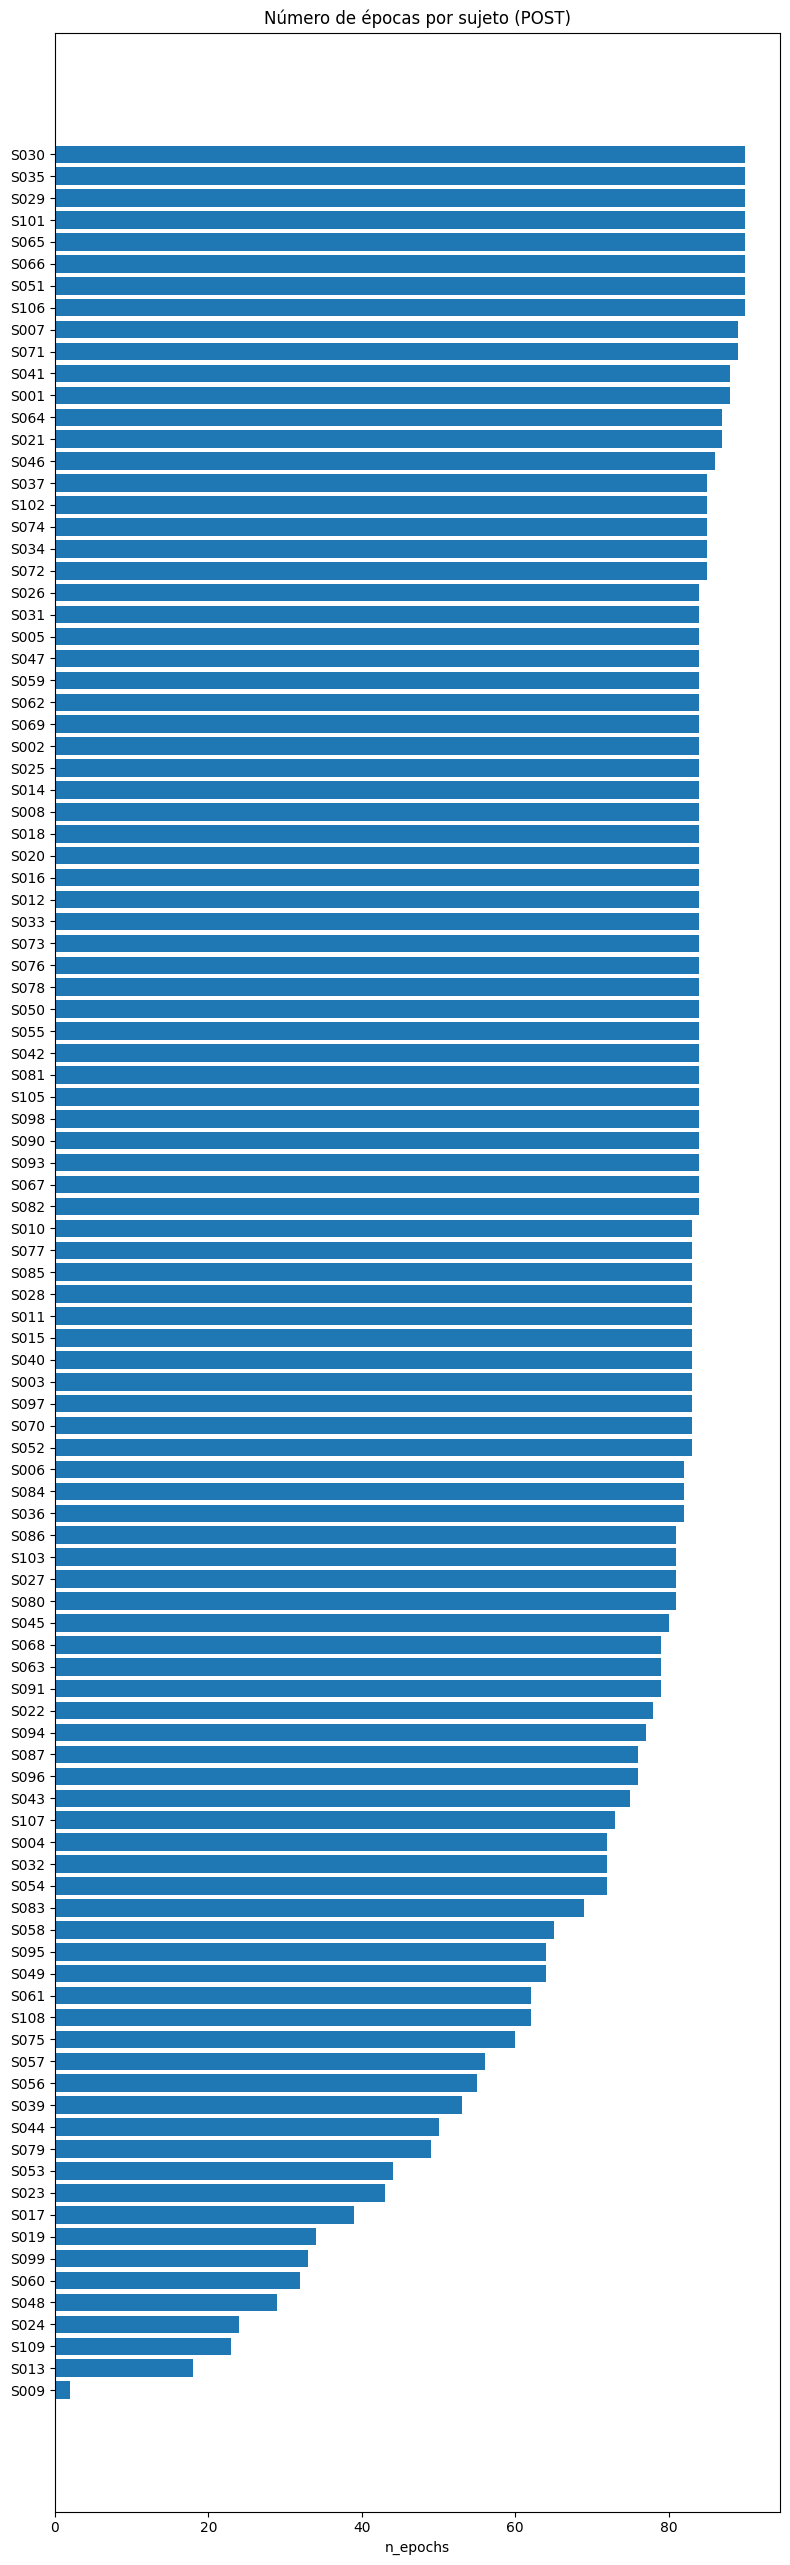

Figura guardada: C:\Users\joelc\Desktop\eeg2\reports\figures\03_proc_eda\cmp_n_epochs_barh.png


In [13]:
# %% [Report Quickview — comparación RAW vs POST]
# Compara métricas clave del EDA RAW vs EDA POST y genera tablas/figuras.
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Rutas (ajusta si tu organización difiere)
PROJ = Path('..').resolve()
RAW_TAB  = PROJ / 'reports' / 'tables'  / '01_EDA_raw'
POST_TAB = PROJ / 'reports' / 'tables'  / '03_proc_eda'
FIG_DIR  = PROJ / 'reports' / 'figures' / '03_proc_eda'
FIG_DIR.mkdir(parents=True, exist_ok=True)

RAW_CSV  = RAW_TAB  / 'metrics_raw_subject.csv'
POST_CSV = POST_TAB / 'metrics_proc_subject.csv'
CMP_CSV  = POST_TAB / 'eda_compare_raw_vs_post.csv'   # salida

def _to_subject_num(val):
    """
    Convierte valores tipo 'S001', '001', 's12', 1, 12 → entero 1, 12, ...
    Si no se puede parsear, devuelve NaN.
    """
    if pd.isna(val):
        return np.nan
    if isinstance(val, (int, np.integer, float, np.floating)):
        try:
            return int(val)
        except Exception:
            return np.nan
    s = str(val).strip()
    m = re.search(r'(\d+)', s)
    return int(m.group(1)) if m else np.nan

def _add_subject_keys(df, col='subject'):
    """
    Añade columnas canónicas:
      - subject_num: entero (clave de merge)
      - subject_tag: 'S%03d' (etiqueta estandarizada)
    """
    df = df.copy()
    if col not in df.columns:
        raise KeyError(f"Columna '{col}' no encontrada en el DataFrame.")
    df['subject_num'] = df[col].apply(_to_subject_num)
    df['subject_tag'] = df['subject_num'].apply(lambda x: f"S{x:03d}" if pd.notna(x) else np.nan)
    return df

def _load_or_build_compare():
    # Cargar métricas
    if not RAW_CSV.exists():
        raise FileNotFoundError(f"No existe RAW: {RAW_CSV}")
    if not POST_CSV.exists():
        raise FileNotFoundError(f"No existe POST: {POST_CSV}")

    df_raw  = pd.read_csv(RAW_CSV)
    df_post = pd.read_csv(POST_CSV)

    # Normalizar ID de sujeto en ambos
    df_raw  = _add_subject_keys(df_raw,  'subject')
    df_post = _add_subject_keys(df_post, 'subject')

    # Resolver posibles duplicados por sujeto manteniendo la primera fila
    df_raw  = df_raw.sort_values('subject_num').drop_duplicates('subject_num', keep='first')
    df_post = df_post.sort_values('subject_num').drop_duplicates('subject_num', keep='first')

    # Columnas a conservar de cada lado
    keep_raw = [
        'subject','subject_num','subject_tag',
        'n_runs_mi',
        'n_events_left','n_events_right','n_events_fists','n_events_feet',
        'std_uV_median','p99_uV_median',
        'silhouette_logvar_raw'
    ]
    keep_post = [
        'subject','subject_num','subject_tag',
        'n_epochs','sfreq','n_channels',
        'emg_ratio_20_40',
        'bandpower_motor_mu_mean','bandpower_motor_beta_mean',
        'silhouette_logvar_post',
        'motor_channels_found',
        'count_Left','count_Right','count_Both Fists','count_Both Feet'
    ]
    keep_raw  = [c for c in keep_raw  if c in df_raw.columns]
    keep_post = [c for c in keep_post if c in df_post.columns]

    # Merge por clave numérica (evita conflicto int vs str)
    df_cmp = pd.merge(
        df_raw[keep_raw],
        df_post[keep_post],
        on='subject_num',
        how='inner',
        suffixes=('_raw','_post')
    )

    # Columna 'subject' estandarizada (S%03d)
    if 'subject_tag_raw' in df_cmp.columns:
        df_cmp['subject'] = df_cmp['subject_tag_raw']
    elif 'subject_tag_post' in df_cmp.columns:
        df_cmp['subject'] = df_cmp['subject_tag_post']
    else:
        df_cmp['subject'] = df_cmp['subject_num'].apply(lambda x: f"S{x:03d}")

    # Ordenar columnas
    cols = ['subject','subject_num'] + [c for c in df_cmp.columns if c not in ('subject','subject_num')]
    df_cmp = df_cmp[cols]

    # Deltas y razones útiles para inspección rápida
    if 'silhouette_logvar_raw' in df_cmp.columns and 'silhouette_logvar_post' in df_cmp.columns:
        df_cmp['delta_silhouette'] = df_cmp['silhouette_logvar_post'] - df_cmp['silhouette_logvar_raw']

    if 'p99_uV_median' in df_cmp.columns and 'emg_ratio_20_40' in df_cmp.columns:
        # ratio EMG por p99 como proxy de “ruido relativo”
        with np.errstate(divide='ignore', invalid='ignore'):
            df_cmp['emg_per_p99'] = df_cmp['emg_ratio_20_40'] / df_cmp['p99_uV_median']

    # Persistir
    df_cmp.to_csv(CMP_CSV, index=False)
    return df_cmp

# Construir/leer comparación
df_cmp = _load_or_build_compare()
print("Comparación RAW vs POST — shape:", df_cmp.shape)
display(df_cmp.head(10))

# --- Figuras rápidas-----------------------------------------

# 1) Barras de Δ Silhouette por sujeto
if 'delta_silhouette' in df_cmp.columns:
    df_plot = df_cmp[['subject','delta_silhouette']].dropna().sort_values('delta_silhouette', ascending=True)
    if not df_plot.empty:
        plt.figure(figsize=(8, max(3, 0.25*len(df_plot))))
        plt.barh(df_plot['subject'], df_plot['delta_silhouette'])
        plt.axvline(0.0, linestyle='--', linewidth=1)
        plt.title('Δ Silhouette (post - raw) por sujeto')
        plt.xlabel('Δ silhouette')
        plt.tight_layout()
        out_png = FIG_DIR / 'cmp_delta_silhouette_barh.png'
        plt.savefig(out_png, dpi=150)
        plt.show()
        print("Figura guardada:", out_png)

# 2) Dispersión p99_uV_median (RAW) vs EMG 20–40 Hz (POST)
if {'p99_uV_median','emg_ratio_20_40'}.issubset(df_cmp.columns):
    df_plot = df_cmp[['subject','p99_uV_median','emg_ratio_20_40']].dropna()
    if not df_plot.empty:
        plt.figure(figsize=(6,5))
        plt.scatter(df_plot['p99_uV_median'], df_plot['emg_ratio_20_40'], alpha=0.8)
        plt.xlabel('p99 amplitud (µV) — RAW')
        plt.ylabel('EMG ratio 20–40 Hz — POST')
        plt.title('Amplitud extrema RAW vs EMG residual POST')
        plt.tight_layout()
        out_png = FIG_DIR / 'cmp_p99_vs_emg_scatter.png'
        plt.savefig(out_png, dpi=150)
        plt.show()
        print("Figura guardada:", out_png)

# 3) Barras de n_epochs (POST) por sujeto, ordenado
if {'subject','n_epochs'}.issubset(df_cmp.columns):
    df_plot = df_cmp[['subject','n_epochs']].dropna().sort_values('n_epochs', ascending=False)
    if not df_plot.empty:
        plt.figure(figsize=(8, max(3, 0.25*len(df_plot))))
        plt.barh(df_plot['subject'], df_plot['n_epochs'])
        plt.gca().invert_yaxis()
        plt.title('Número de épocas por sujeto (POST)')
        plt.xlabel('n_epochs')
        plt.tight_layout()
        out_png = FIG_DIR / 'cmp_n_epochs_barh.png'
        plt.savefig(out_png, dpi=150)
        plt.show()
        print("Figura guardada:", out_png)


# Análisis del Preprocesamiento de EEG

En esta etapa realizamos un análisis comparativo **antes (RAW)** y **después (POST)** del pipeline de preprocesamiento aplicado a los datos de EEG de Imaginería Motora (MI). El objetivo fue verificar si las transformaciones realizadas (filtrado, normalización de canales, detección de artefactos, construcción de epochs, etc.) realmente mejoraron la **calidad de señal** y la **separabilidad de clases**.

---

## Hallazgos principales

### 1. Inventario y calidad de sujetos
- La mayoría de los sujetos quedaron con **72–90 épocas útiles**, lo que asegura un volumen de datos estable para experimentos intra-sujeto y LOSO.  
- Algunos sujetos (ej. `S009`, `S013`, `S019`) quedaron con **muy pocas épocas (<30)**. Estos casos deben ser marcados como de **baja calidad** para no sesgar los resultados globales.

### 2. Métricas de amplitud
- En los datos RAW, las amplitudes extremas (`p99_uV`) alcanzaban valores muy altos (>200 μV), reflejando artefactos (parpadeos, EMG, ruido eléctrico).  
- Después del preprocesamiento, la **amplitud extrema bajó de manera consistente**, lo cual indica un filtrado más estable.  
- Sin embargo, la reducción de amplitud **no siempre se correlaciona** con reducción de EMG (actividad muscular residual).

### 3. Ruido muscular (EMG ratio 20–40 Hz)
- La mayoría de sujetos quedaron en un rango razonable (0.5–2.5).  
- Algunos casos muestran valores elevados (>3), indicando que todavía hay **actividad muscular residual** en la banda beta alta.  
- Estos sujetos pueden requerir un filtrado adicional o inspección manual.

### 4. Separabilidad de clases (Silhouette log-var)
- El índice **Silhouette** (calculado sobre features log-var) fue usado como proxy de qué tan separables son las clases.  
- En **muchos sujetos el delta Silhouette (POST – RAW) fue positivo**, lo cual confirma que el preprocesamiento ayudó a mejorar la discriminación entre clases.  
- No obstante, algunos sujetos mostraron **empeoramiento (valores más negativos)**. Esto refleja que un único conjunto de parámetros no siempre es óptimo para todos los sujetos.

---

## Conclusiones

1. El pipeline de preprocesamiento es **sólido y estandarizado**, generando datos limpios y listos para modelado.  
2. El impacto es **positivo en la mayoría de sujetos**, especialmente en la reducción de amplitud extrema y en la mejoría del índice de separabilidad.  
3. Se identifican **outliers y casos problemáticos**:
   - Sujetos con muy pocas épocas.
   - Sujetos con EMG residual alto.
   - Sujetos con Δ Silhouette negativo fuerte.  
   Estos casos deben ser marcados con **QA flags** para decidir si se incluyen o se excluyen en entrenamientos globales.  
4. El siguiente paso no debería ser modificar más el preprocesamiento global, sino empezar a **probar modelos (FBCSP+LDA, CNNs, Riemannianos, etc.)** y observar si estos sujetos problemáticos afectan los resultados.

---

## Leyenda de términos importantes

- **Epochs**: segmentos de señal EEG recortados alrededor de los eventos de interés (ej. 0.5–4.5 s después de la instrucción).  
- **p99_uV**: percentil 99 de amplitud en microvoltios. Una medida de amplitud extrema sin ser tan sensible a outliers únicos.  
- **EMG (Electromiografía residual)**: actividad muscular que contamina la señal EEG, suele verse en bandas altas (20–40 Hz).  
- **EMG ratio (20–40 Hz)**: proporción de potencia espectral en esa banda. Valores altos indican ruido muscular persistente.  
- **PSD (Power Spectral Density)**: estimación de la distribución de potencia de la señal en función de la frecuencia. Se usa para ver si aparecen picos de ruido (ej. 50/60 Hz) o si se distinguen bandas mu y beta.  
- **Bandpower μ (8–12 Hz)**: potencia en la banda mu, asociada a imaginaciones motoras (desincronización en C3/C4).  
- **Bandpower β (13–30 Hz)**: potencia en la banda beta, también relevante en MI.  
- **Silhouette log-var**: índice de separabilidad entre clases calculado sobre features de varianza logarítmica.  
   - Valores positivos indican **clases más separables**.  
   - Valores negativos indican **clases mezcladas**.  
   - El delta (POST – RAW) sirve para evaluar si el preprocesamiento mejoró o no la separabilidad.  
- **QA (Quality Assurance) flags**: reglas automáticas para marcar sujetos con problemas (pocas épocas, EMG alto, Δ silhouette negativo).

---
